In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
from replay_buffer import ReplayBuffer
import numpy as np
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node

Delay_VoltageSampling = np.array([0,0,0,0,0, 10,10,10,10,10,10,10,10,10,10,10,10,10, 0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
Origin_Load = LoadSeconds
Origin_Generation = GenerationSeconds

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...


In [2]:
############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1, solar_irr, VBP, Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def adaptive_control(delay, vk, vkmdelay, ukmdelay, thresh, yk):
    if (yk > thresh):
        uk = delay/2*k * ( vk**2 + vkmdelay**2 ) + ukmdelay
    else:
        uk = ukmdelay
    return uk

In [3]:
#support function
def processing_state(V, G, L):
    state = np.array([V, G, L]).T
    result = np.zeros((60,3))
    result[:state.shape[0],:state.shape[1]] = state #padding with zeros
    state = result.copy()
    return state

In [4]:
#this is the agent
import tensorflow as tf
EPS = 1e-6

def build_graph(inputs, layer_sizes, non_linearlayer=False):
    if type(inputs) is tf.Tensor:
        inputs = [inputs]
    
    with tf.variable_scope('layer0'):
        state = inputs[0]
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units=32, use_peepholes=True)
        outputs, states = tf.nn.dynamic_rnn(lstm_cell, state, dtype=tf.float32)
        state0 = tf.layers.dense(states.h, 30)
        if len(inputs) != 1:
            action = inputs[1]
            action0 = tf.layers.dense(action, 30)
            layer = action0 + state0
        else: 
            layer = state0
        layer = tf.nn.relu(layer)
    
    for i_layer, size in enumerate(layer_sizes, 1):
        with tf.variable_scope('layer{0}'.format(i_layer)):
            layer = tf.layers.dense(layer, size)
            if i_layer < len(layer_sizes) - 1:
                layer = tf.nn.relu(layer)
    
    if non_linearlayer==True:
        layer = tf.nn.tanh(layer)
    
    return layer

class NNFunction():
    def __init__(self, name, input_pls, hidden_layer_sizes):
        self._name = name
        self._input_pls = input_pls
        if name != 'policy':
            self._layer_sizes = list(hidden_layer_sizes) + [1]
        else:
            self._layer_sizes = list(hidden_layer_sizes) + [4]
        self._output_t = self.get_output_for(*self._input_pls)
    def get_output_for(self, *inputs, reuse=False):
        with tf.variable_scope(self._name, reuse=reuse):
            value_t = build_graph(inputs=inputs, layer_sizes=self._layer_sizes)
        return value_t
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )

class NNQFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30,30), name='qf'):
        self._Da = 4
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None]+ self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        super(NNQFunction, self).__init__(name, (self._obs_pl, self._action_pl), hidden_layer_sizes)

#############################################################        
    
class Policy(NNFunction):
    def __init__(self, hidden_layer_sizes=(30,30), reparameterize=False, name='policy', squash=True):
        self._name = name
        self._Do = [60,3]
        self._Da = 4
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        self._layer_sizes = hidden_layer_sizes
        super(Policy, self).__init__(name, (self._obs_pl,), hidden_layer_sizes)
        
    def actions_for(self, observations, reuse=tf.AUTO_REUSE):
        name = self._name
        with tf.variable_scope(name, reuse=reuse):
            actions = build_graph(inputs=observations, layer_sizes=self._layer_sizes, non_linearlayer=True)        
        return actions    
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
    def _squash_correction(self, actions):
        if not self._squash: return 0
        return tf.reduce_sum(tf.log(1 - tf.tanh(actions) ** 2 + EPS), axis=1)
    
    def name(self):
        return self._name

class agent():
    def __init__(self, sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph, name='agent'):
        self._observations_ph = observations_ph
        self._next_observations_ph = next_observations_ph
        self._rewards_ph = rewards_ph
        self._actions_ph= actions_ph
        self._terminals_ph = terminals_ph
        
        self._discount = 0.99
        self._tau = 0.01
        
        self._qf_lr = 0.1
        self._vf_lr = 0.1
        self._policy_lr = 0.01
        self._action_prior = 'Normal'
        self._reparameterize = False
        self._sess = sess
        self._training_ops = []
        
        with tf.variable_scope(name):
            self._qf = NNQFunction((30,30), 'qf')
            self._policy = Policy(hidden_layer_sizes=(30,30))
            self._init_critic_update()
            self._init_actor_update()
            self._init_target_ops()
            
        uninit_vars = []
        for var in tf.global_variables():
            try:
                self._sess.run(var)
            except tf.errors.FailedPreconditionError:
                uninit_vars.append(var)
        self._sess.run(tf.variables_initializer(uninit_vars))
        
        self._init_training()
        
    def _init_critic_update(self):
        self._qf_t = self._qf.get_output_for(self._observations_ph, self._actions_ph, reuse=True)
        
        with tf.variable_scope('target_policy'):
            actions = self._policy.actions_for(self._next_observations_ph)
            self._policy_target_params = self._policy.get_params_internal()
        
        with tf.variable_scope('target_qf'):
            self._qf_t_next = self._qf.get_output_for(self._next_observations_ph, actions)        
            self._qf_target_params = self._qf.get_params_internal()
        ys = tf.stop_gradient(
            self._rewards_ph +
            (1 - self._terminals_ph) * self._discount * self._qf_t_next)  
        
        self._td_loss_t = 0.5 * tf.reduce_mean((ys - self._qf_t)**2)
        qf_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss_t,
            var_list=self._qf.get_params_internal()
        )
        self._training_ops.append(qf_train_op)
        
    def _init_actor_update(self):
        self._action = self._policy.actions_for(self._observations_ph, reuse=True)
        self._policy_params = self._policy.get_params_internal()
        self._qf_t = self._qf.get_output_for(self._observations_ph, self._actions_ph, reuse=True)
        self._qf_params = self._qf.get_params_internal()
        
        q_grads = tf.negative(tf.gradients(self._qf_t, self._actions_ph))
        grads = tf.gradients(self._action, self._policy_params, q_grads)
        
        grads = list(map(lambda x: tf.div(x, 30), grads))
        policy_train_op = tf.train.AdamOptimizer(self._policy_lr).apply_gradients(zip(grads, self._policy.get_params_internal()))
        self._training_ops.append(policy_train_op)        
        
    def _init_target_ops(self):
        """Create tensorflow operations for updating target value function."""

        source_params = self._qf_params
        target_params = self._qf_target_params
        
        self._target_ops_qf = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]
        
        source_params_p = self._policy_params
        target_params_p = self._policy_target_params

        self._target_ops_p = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params_p, source_params_p)
        ]

    def _init_training(self):
        self._sess.run(self._target_ops_qf)
        self._sess.run(self._target_ops_p)

    def do_training(self, batch):
        """Runs the operations for updating training and target ops."""

        feed_dict = self._get_feed_dict(batch)
        self._sess.run(self._training_ops[0], feed_dict)
        self._sess.run(self._training_ops[1], feed_dict)
        self._sess.run(self._target_ops_qf)
        self._sess.run(self._target_ops_p)

    def _get_feed_dict(self, batch):
        """Construct TensorFlow feed_dict from sample batch."""

        feed_dict = {
            self._observations_ph: batch['observations'],
            self._actions_ph: batch['actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_ph: batch['rewards'],
            self._terminals_ph: batch['terminals'],
        }
        return feed_dict
   
    def action_respond(self, obs):
        action = self._action
        a = self._sess.run([action], feed_dict={observations_ph: obs})[0][0]
        return a
    
def init_placeholder():
    observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='observation')
    next_observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='next_observation')
    rewards_ph = tf.placeholder(tf.float32, shape=(None, 1), name='reward')
    actions_ph = tf.placeholder(tf.float32, shape=(None, 4), name='action')
    terminals_ph = tf.placeholder(tf.float32, shape=(None, 1), name='terminal')
    return observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph

D:\Apps\Anacoda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
sess = tf.Session()
agent = agent(sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph)

In [ ]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.005, theta=.1, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)
    

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


D:\Apps\Anacoda3\lib\site-packages\ipykernel_launcher.py:256: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


-11164.299637366821
--- 61.218092918395996 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


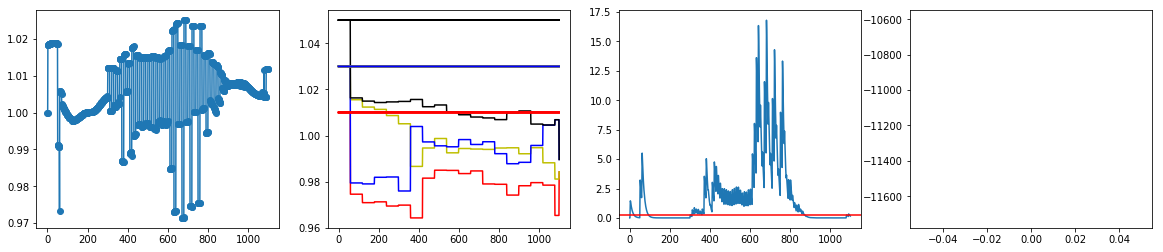

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 1.4173166751861572 seconds ---
--- 0.08415985107421875 seconds ---
--- 0.08799958229064941 seconds ---
--- 0.08357882499694824 seconds ---
--- 0.08273863792419434 seconds ---
--- 0.08955192565917969 seconds ---
--- 0.07662177085876465 seconds ---
-11164.299637366821
--- 75.34331631660461 seconds ---


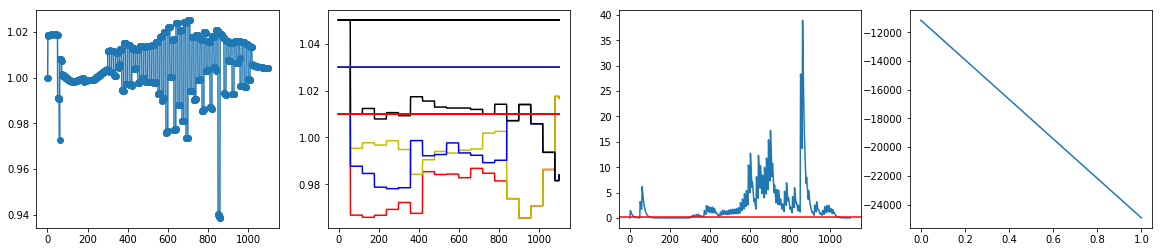

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.09799957275390625 seconds ---
--- 0.07315731048583984 seconds ---
--- 0.09431958198547363 seconds ---
--- 0.08458256721496582 seconds ---
--- 0.07950687408447266 seconds ---
--- 0.08489108085632324 seconds ---
--- 0.0800027847290039 seconds ---
--- 0.09125208854675293 seconds ---
--- 0.09340763092041016 seconds ---
--- 0.0786292552947998 seconds ---
--- 0.0887746810913086 seconds ---
--- 0.0823507308959961 seconds ---
--- 0.08571290969848633 seconds ---
--- 0.08276915550231934 seconds ---
--- 0.09103751182556152 seconds ---
--- 0.08049798011779785 seconds ---
--- 0.10415029525756836 seconds ---
--- 0.0838170051574707 seconds ---
--- 0.09065604209899902 seconds ---
-1314.2881846358289
--- 83.65478730201721 seconds ---


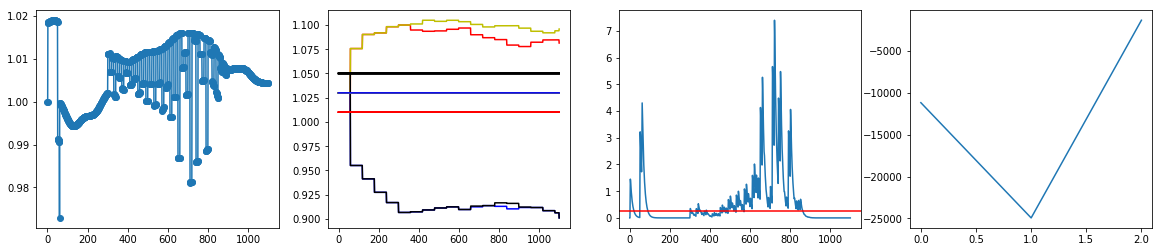

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07249736785888672 seconds ---
--- 0.07795190811157227 seconds ---
--- 0.0757439136505127 seconds ---
--- 0.0782163143157959 seconds ---
--- 0.08980107307434082 seconds ---
--- 0.07456111907958984 seconds ---
--- 0.08530783653259277 seconds ---
--- 0.08834481239318848 seconds ---
--- 0.07967662811279297 seconds ---
--- 0.0929100513458252 seconds ---
--- 0.10376405715942383 seconds ---
--- 0.0877847671508789 seconds ---
--- 0.07976388931274414 seconds ---
--- 0.08813905715942383 seconds ---
--- 0.0785820484161377 seconds ---
--- 0.07859039306640625 seconds ---
--- 0.08319592475891113 seconds ---
--- 0.06781625747680664 seconds ---
--- 0.08470535278320312 seconds ---
-1314.2881846358289
--- 79.97605729103088 seconds ---


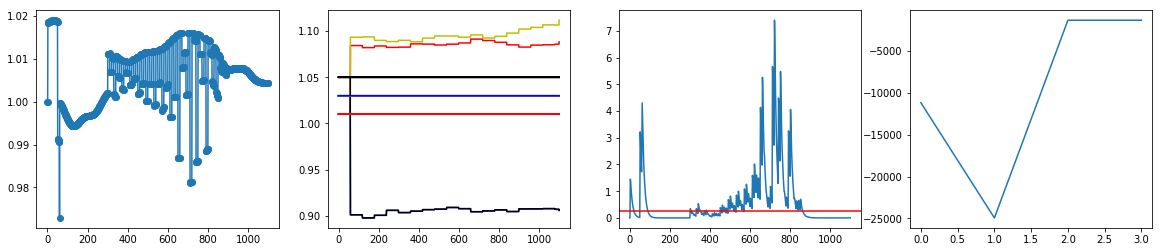

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07314085960388184 seconds ---
--- 0.0806427001953125 seconds ---
--- 0.07965826988220215 seconds ---
--- 0.07695245742797852 seconds ---
--- 0.0671541690826416 seconds ---
--- 0.10373115539550781 seconds ---
--- 0.08002996444702148 seconds ---
--- 0.08676624298095703 seconds ---
--- 0.0901956558227539 seconds ---
--- 0.08160591125488281 seconds ---
--- 0.10436058044433594 seconds ---
--- 0.07569599151611328 seconds ---
--- 0.08285641670227051 seconds ---
--- 0.0837705135345459 seconds ---
--- 0.09241461753845215 seconds ---
--- 0.08725309371948242 seconds ---
--- 0.07181310653686523 seconds ---
--- 0.07924032211303711 seconds ---
--- 0.08648943901062012 seconds ---
-1314.2881846358289
--- 83.38956046104431 seconds ---


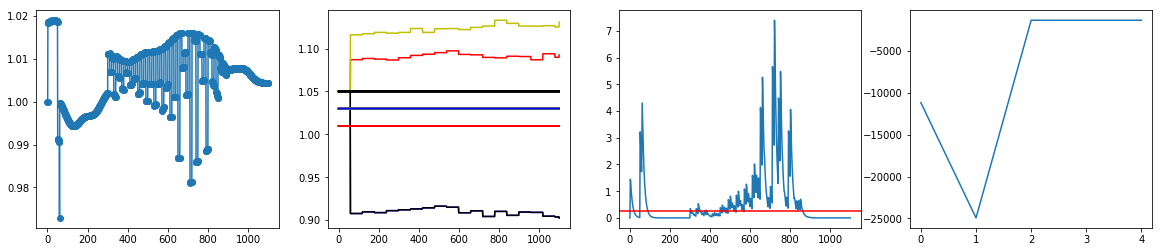

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07902765274047852 seconds ---
--- 0.07297039031982422 seconds ---
--- 0.07581162452697754 seconds ---
--- 0.0807645320892334 seconds ---
--- 0.0921781063079834 seconds ---
--- 0.07864785194396973 seconds ---
--- 0.08895277976989746 seconds ---
--- 0.09367847442626953 seconds ---
--- 0.08091425895690918 seconds ---
--- 0.10023736953735352 seconds ---
--- 0.09003090858459473 seconds ---
--- 0.08339691162109375 seconds ---
--- 0.08276820182800293 seconds ---
--- 0.1006174087524414 seconds ---
--- 0.06333470344543457 seconds ---
--- 0.07348847389221191 seconds ---
--- 0.08239078521728516 seconds ---
--- 0.09261393547058105 seconds ---
--- 0.08402800559997559 seconds ---
-1314.2881846358289
--- 82.71232032775879 seconds ---


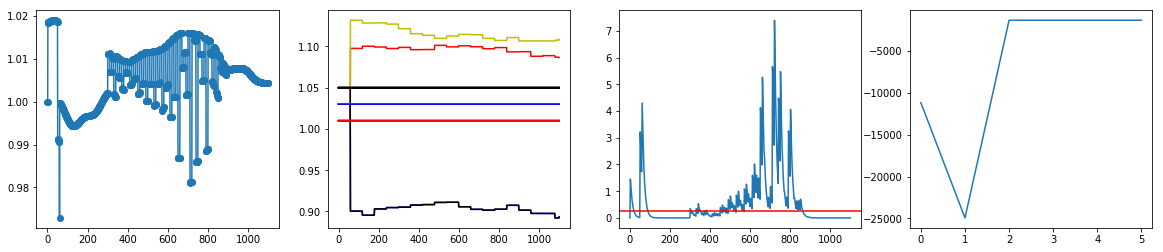

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.07404565811157227 seconds ---
--- 0.08065009117126465 seconds ---
--- 0.09350800514221191 seconds ---
--- 0.08540749549865723 seconds ---
--- 0.07506990432739258 seconds ---
--- 0.08142352104187012 seconds ---
--- 0.09205985069274902 seconds ---
--- 0.06790471076965332 seconds ---
--- 0.09216666221618652 seconds ---
--- 0.0787959098815918 seconds ---
--- 0.10372424125671387 seconds ---
--- 0.07825493812561035 seconds ---
--- 0.07176589965820312 seconds ---
--- 0.08431386947631836 seconds ---
--- 0.09072065353393555 seconds ---
--- 0.08727574348449707 seconds ---
--- 0.06933903694152832 seconds ---
--- 0.09345507621765137 seconds ---
--- 0.09554696083068848 seconds ---
-1314.2881846358289
--- 80.64147305488586 seconds ---


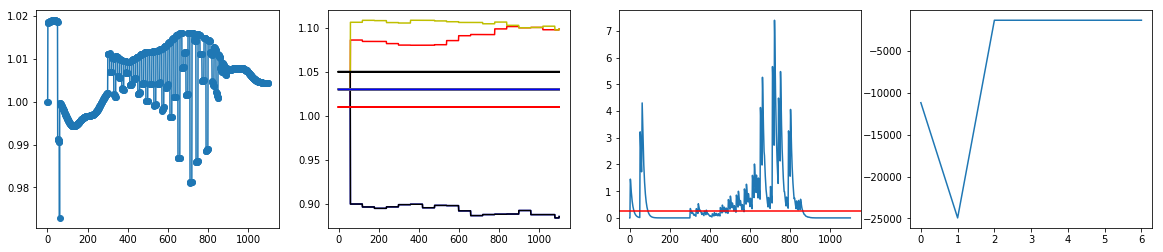

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.055849552154541016 seconds ---
--- 0.052857160568237305 seconds ---
--- 0.05186104774475098 seconds ---
--- 0.049865007400512695 seconds ---
--- 0.04229474067687988 seconds ---
--- 0.05684781074523926 seconds ---
--- 0.0503230094909668 seconds ---
--- 0.05032181739807129 seconds ---
--- 0.04826521873474121 seconds ---
--- 0.04023909568786621 seconds ---
--- 0.050862789154052734 seconds ---
--- 0.04886817932128906 seconds ---
--- 0.04387950897216797 seconds ---
--- 0.04786968231201172 seconds ---
--- 0.05086350440979004 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.046874284744262695 seconds ---
--- 0.05186009407043457 seconds ---
--- 0.04587578773498535 seconds ---
-1314.2881846358289
--- 62.965115785598755 seconds ---


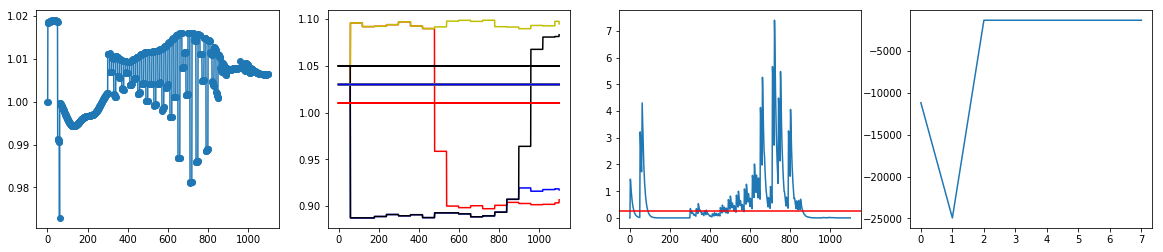

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.043882131576538086 seconds ---
--- 0.04388236999511719 seconds ---
--- 0.04787039756774902 seconds ---
--- 0.06475496292114258 seconds ---
--- 0.05029869079589844 seconds ---
--- 0.05684685707092285 seconds ---
--- 0.04586958885192871 seconds ---
--- 0.05035400390625 seconds ---
--- 0.04787182807922363 seconds ---
--- 0.04886984825134277 seconds ---
--- 0.05032682418823242 seconds ---
--- 0.04787135124206543 seconds ---
--- 0.05584859848022461 seconds ---
--- 0.04930233955383301 seconds ---
--- 0.05385470390319824 seconds ---
--- 0.04787182807922363 seconds ---
--- 0.050333499908447266 seconds ---
--- 0.05684828758239746 seconds ---
--- 0.05030512809753418 seconds ---
-1314.2881846358289
--- 59.41703248023987 seconds ---


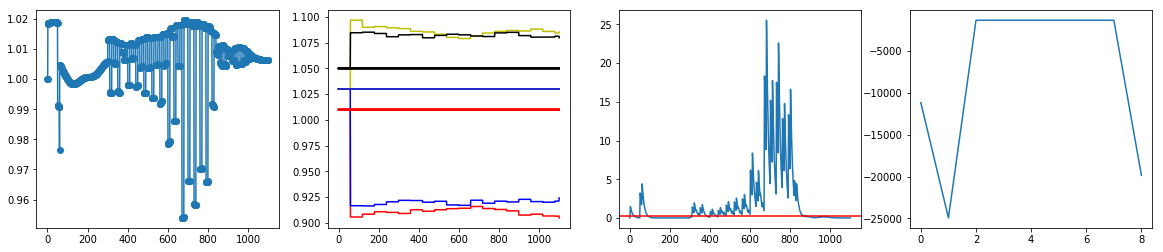

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.05231809616088867 seconds ---
--- 0.052857160568237305 seconds ---
--- 0.05029654502868652 seconds ---
--- 0.05029749870300293 seconds ---
--- 0.04986429214477539 seconds ---
--- 0.050328969955444336 seconds ---
--- 0.046872615814208984 seconds ---
--- 0.04587674140930176 seconds ---
--- 0.04388070106506348 seconds ---
--- 0.04687309265136719 seconds ---
--- 0.04776144027709961 seconds ---
--- 0.048868656158447266 seconds ---
--- 0.05485129356384277 seconds ---
--- 0.05584907531738281 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.041941165924072266 seconds ---
--- 0.04487752914428711 seconds ---
--- 0.046874284744262695 seconds ---
--- 0.06782245635986328 seconds ---
-1314.2881846358289
--- 60.84484601020813 seconds ---


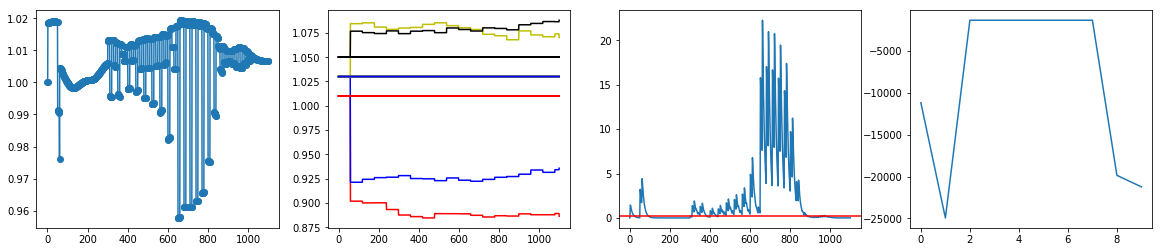

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04687380790710449 seconds ---
--- 0.04487800598144531 seconds ---
--- 0.047872066497802734 seconds ---
--- 0.0578465461730957 seconds ---
--- 0.04787135124206543 seconds ---
--- 0.04787278175354004 seconds ---
--- 0.05285763740539551 seconds ---
--- 0.04226183891296387 seconds ---
--- 0.05185985565185547 seconds ---
--- 0.0528562068939209 seconds ---
--- 0.04786944389343262 seconds ---
--- 0.04487967491149902 seconds ---
--- 0.048870086669921875 seconds ---
--- 0.05684638023376465 seconds ---
--- 0.06037497520446777 seconds ---
--- 0.04886913299560547 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.052371978759765625 seconds ---
--- 0.050284624099731445 seconds ---
-1314.2881846358289
--- 62.3058340549469 seconds ---


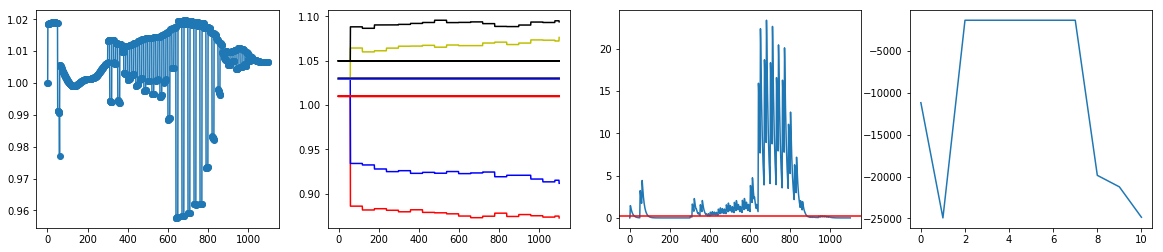

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04388236999511719 seconds ---
--- 0.051860809326171875 seconds ---
--- 0.04188871383666992 seconds ---
--- 0.046875715255737305 seconds ---
--- 0.05086183547973633 seconds ---
--- 0.05485129356384277 seconds ---
--- 0.05086231231689453 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.04488825798034668 seconds ---
--- 0.047872066497802734 seconds ---
--- 0.04787278175354004 seconds ---
--- 0.04787158966064453 seconds ---
--- 0.051862239837646484 seconds ---
--- 0.05984044075012207 seconds ---
--- 0.04886960983276367 seconds ---
--- 0.04787278175354004 seconds ---
--- 0.05186128616333008 seconds ---
--- 0.05243849754333496 seconds ---
--- 0.043882131576538086 seconds ---
-1314.2881846358289
--- 65.48397660255432 seconds ---


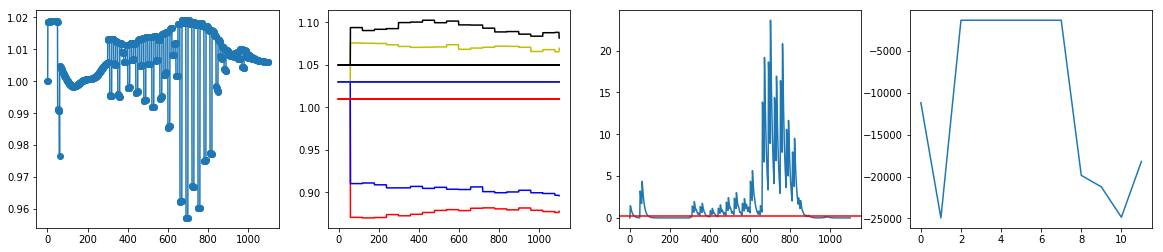

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.050348758697509766 seconds ---
--- 0.04023337364196777 seconds ---
--- 0.05031299591064453 seconds ---
--- 0.050863027572631836 seconds ---
--- 0.06042218208312988 seconds ---
--- 0.04787158966064453 seconds ---
--- 0.05284690856933594 seconds ---
--- 0.050864458084106445 seconds ---
--- 0.046872615814208984 seconds ---
--- 0.04787158966064453 seconds ---
--- 0.046875 seconds ---
--- 0.049866437911987305 seconds ---
--- 0.052356719970703125 seconds ---
--- 0.048868656158447266 seconds ---
--- 0.04024839401245117 seconds ---
--- 0.04028034210205078 seconds ---
--- 0.05031132698059082 seconds ---
--- 0.05384969711303711 seconds ---
--- 0.05086398124694824 seconds ---
-1314.2881846358289
--- 59.35967755317688 seconds ---


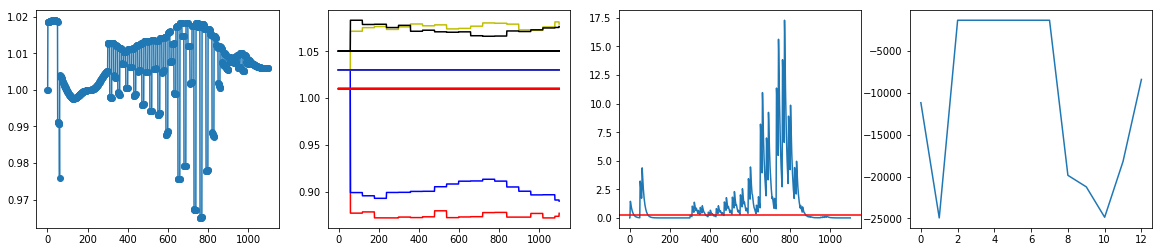

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06283164024353027 seconds ---
--- 0.05285835266113281 seconds ---
--- 0.050336599349975586 seconds ---
--- 0.04829668998718262 seconds ---
--- 0.044878482818603516 seconds ---
--- 0.05037426948547363 seconds ---
--- 0.04587268829345703 seconds ---
--- 0.056841135025024414 seconds ---
--- 0.0468745231628418 seconds ---
--- 0.05186128616333008 seconds ---
--- 0.04886770248413086 seconds ---
--- 0.04388308525085449 seconds ---
--- 0.05834674835205078 seconds ---
--- 0.05032205581665039 seconds ---
--- 0.04225754737854004 seconds ---
--- 0.05186033248901367 seconds ---
--- 0.04587674140930176 seconds ---
--- 0.04986834526062012 seconds ---
--- 0.04587697982788086 seconds ---
-1314.2881846358289
--- 64.89657831192017 seconds ---


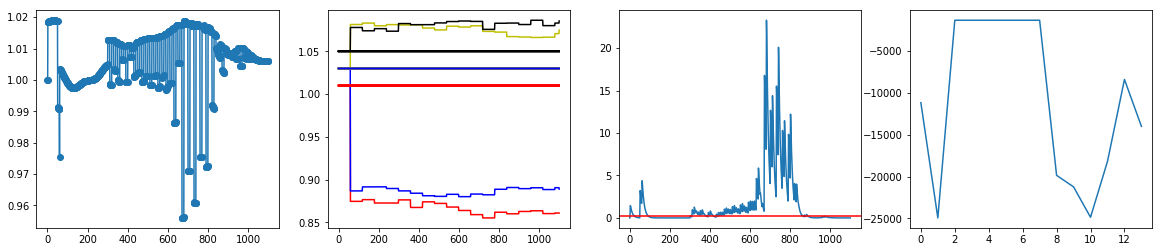

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04587531089782715 seconds ---
--- 0.0498661994934082 seconds ---
--- 0.05984044075012207 seconds ---
--- 0.046874284744262695 seconds ---
--- 0.04787135124206543 seconds ---
--- 0.04288434982299805 seconds ---
--- 0.047870635986328125 seconds ---
--- 0.044878244400024414 seconds ---
--- 0.04388284683227539 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.053856611251831055 seconds ---
--- 0.04886889457702637 seconds ---
--- 0.0528562068939209 seconds ---
--- 0.04388308525085449 seconds ---
--- 0.05285763740539551 seconds ---
--- 0.05037498474121094 seconds ---
--- 0.05385589599609375 seconds ---
--- 0.047377824783325195 seconds ---
--- 0.05684685707092285 seconds ---
-1314.2881846358289
--- 72.84778118133545 seconds ---


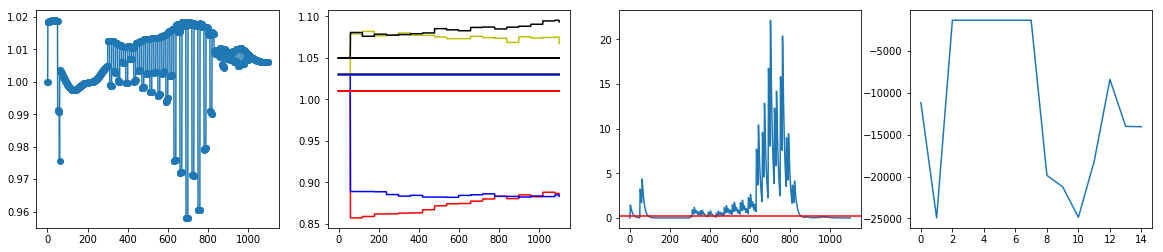

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.044878244400024414 seconds ---
--- 0.04886984825134277 seconds ---
--- 0.04487872123718262 seconds ---
--- 0.04288506507873535 seconds ---
--- 0.05485057830810547 seconds ---
--- 0.04388070106506348 seconds ---
--- 0.04687309265136719 seconds ---
--- 0.04787111282348633 seconds ---
--- 0.05185985565185547 seconds ---
--- 0.046877384185791016 seconds ---
--- 0.04986715316772461 seconds ---
--- 0.0498659610748291 seconds ---
--- 0.06283140182495117 seconds ---
--- 0.054852962493896484 seconds ---
--- 0.048868656158447266 seconds ---
--- 0.04687237739562988 seconds ---
--- 0.05285906791687012 seconds ---
--- 0.04787111282348633 seconds ---
--- 0.046874284744262695 seconds ---
-1314.2881846358289
--- 77.45600199699402 seconds ---


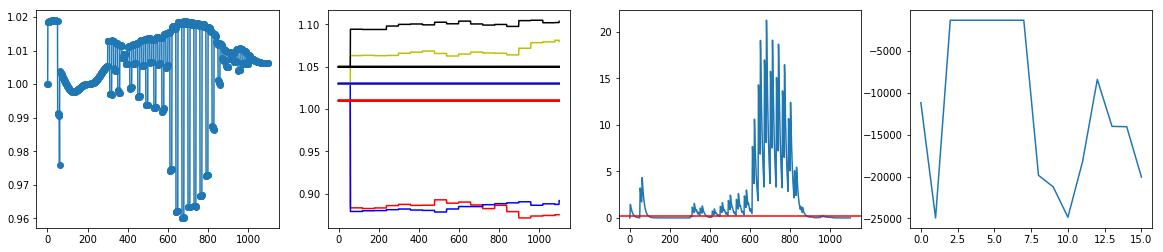

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04022645950317383 seconds ---
--- 0.044876813888549805 seconds ---
--- 0.0503077507019043 seconds ---
--- 0.05234718322753906 seconds ---
--- 0.0468745231628418 seconds ---
--- 0.04886913299560547 seconds ---
--- 0.042314767837524414 seconds ---
--- 0.05034685134887695 seconds ---
--- 0.05485248565673828 seconds ---
--- 0.0608367919921875 seconds ---
--- 0.0478663444519043 seconds ---
--- 0.05030083656311035 seconds ---
--- 0.055849552154541016 seconds ---
--- 0.047872066497802734 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.04686617851257324 seconds ---
--- 0.04787111282348633 seconds ---
--- 0.04587674140930176 seconds ---
--- 0.04687356948852539 seconds ---
-1314.2881846358289
--- 61.67277503013611 seconds ---


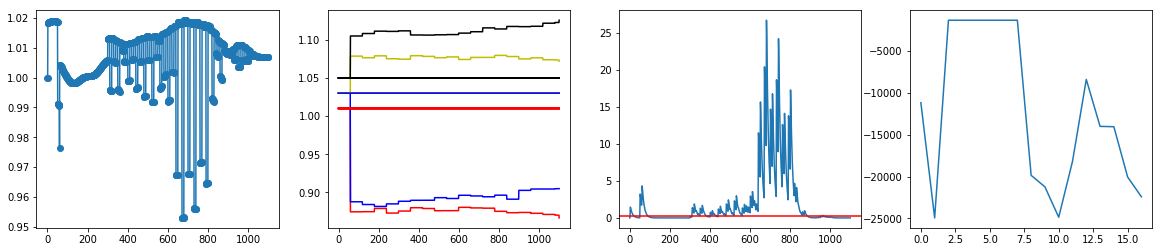

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04487800598144531 seconds ---
--- 0.048868417739868164 seconds ---
--- 0.0608363151550293 seconds ---
--- 0.044881582260131836 seconds ---
--- 0.04986691474914551 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.047869205474853516 seconds ---
--- 0.044878244400024414 seconds ---
--- 0.057843923568725586 seconds ---
--- 0.05086231231689453 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.05086350440979004 seconds ---
--- 0.048868417739868164 seconds ---
--- 0.04886913299560547 seconds ---
--- 0.0468745231628418 seconds ---
--- 0.04986572265625 seconds ---
--- 0.04887032508850098 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.05884385108947754 seconds ---
-1314.2881846358289
--- 63.77423429489136 seconds ---


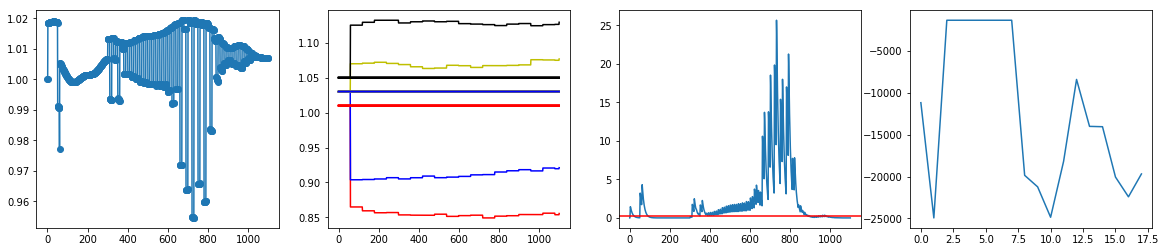

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06183433532714844 seconds ---
--- 0.05385470390319824 seconds ---
--- 0.05086183547973633 seconds ---
--- 0.0608367919921875 seconds ---
--- 0.0528569221496582 seconds ---
--- 0.056845664978027344 seconds ---
--- 0.05983877182006836 seconds ---
--- 0.05485129356384277 seconds ---
--- 0.05086350440979004 seconds ---
--- 0.06482625007629395 seconds ---
--- 0.05035090446472168 seconds ---
--- 0.04787039756774902 seconds ---
--- 0.04687309265136719 seconds ---
--- 0.06283140182495117 seconds ---
--- 0.06283259391784668 seconds ---
--- 0.048868417739868164 seconds ---
--- 0.06183290481567383 seconds ---
--- 0.05684781074523926 seconds ---
--- 0.04886913299560547 seconds ---
-1314.2881846358289
--- 68.70289707183838 seconds ---


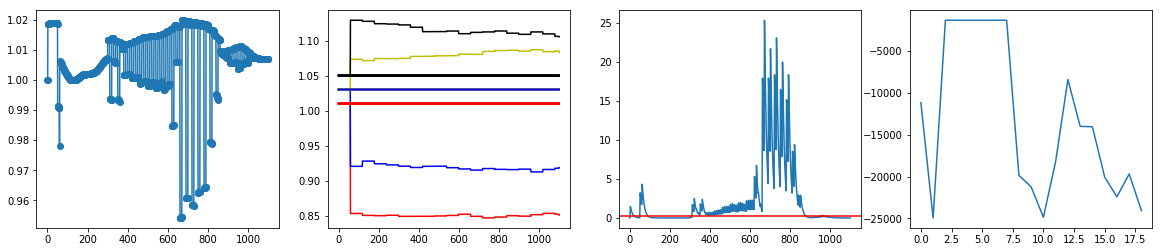

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06183362007141113 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.04687380790710449 seconds ---
--- 0.04787135124206543 seconds ---
--- 0.06582522392272949 seconds ---
--- 0.05684828758239746 seconds ---
--- 0.04886770248413086 seconds ---
--- 0.046875 seconds ---
--- 0.050862789154052734 seconds ---
--- 0.048866987228393555 seconds ---
--- 0.05086350440979004 seconds ---


In [ ]:
totalPoints = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
############################################
########### INIT FOR AGENT #################
############################################

#init action
oldAction = []
action = []

#init state
oldState = []
state = []

#init reward
reward = None

mb_state=[]
mb_action=[]
mb_reward=[]
mb_nextstate=[]
buffer = ReplayBuffer(300)
BATCH_SIZE = 30

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(4), sigma=0.3, theta=.1, dt=1e-2)
epsilon = 1
EXPLORE = 144100

for ep in range(50):
    Load = Origin_Load.copy()
    Generation = Origin_Generation.copy()
    #this is for permutate the Load and Generation profile on each node
    #Load = np.random.permutation(Load.T).T
    #Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(7,8))    
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    terminal = False
    
    for timeStep in range(TotalTimeSteps):
        epsilon -= 1/EXPLORE
        
        VBPcounter = [x+1 for x in VBPcounter] 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1
                            
                        #get State
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            if VBPcounter[node-offset] == Delay_VBPCurveShift[node] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[node]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    length = VBPcounter[node-offset]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    
                                oldState = state
                                state = processing_state(V,G,L)
                                #reset VBPcounter
                                VBPcounter[node-offset] = 0
                                #store action                        
                                oldAction = copy.deepcopy(action)
                                
                                #get Action from Agent
                                action = agent.action_respond(state.reshape((1,60,3)))
                                action += noise() * max(epsilon, 0)
                                #apply strict boundary
                                if action[1] < action[0]:
                                    action[0] = action[1]
                                if action[3] < action[2]:
                                    action[2] = action[3]
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(action*0.1 + 1)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points[node-offset] += reward
                                
                                
                                if oldAction != [] and oldState != []:
                                    if terminal: 
                                        ter = 1
                                    else:
                                        ter = 0
                                    buffer.add(oldState.reshape((60,3)), oldAction, np.array([reward]), np.array([ter]), state.reshape((60,3)))
                                
                                if buffer.size() > BATCH_SIZE:
                                    batch = {}
                                    mb_state, mb_action, mb_reward, mb_ter, mb_nextstate = buffer.sample_batch(BATCH_SIZE)
                                    batch['observations'] = mb_state
                                    batch['actions'] = mb_action
                                    batch['rewards'] = mb_reward
                                    batch['next_observations'] = mb_nextstate
                                    batch['rewards'] = mb_reward
                                    batch['terminals'] = mb_ter
                                    start_time_train = time.time()
                                    agent.do_training(batch)
                                    print("--- %s seconds ---" % (time.time() - start_time_train))
                        #################################################                        
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]

    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(7,8):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints[7-offset])
    plt.show(block=True)
    f.savefig(str(ep) + '.png')
